# Parallel test to validate assumptions required to do a DiD on a log-linear specification

In [57]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_excel('/Users/souhil/Desktop/Courses/Recherche Empirique/Final/Data/cleaned/crimes_subject_to_law_cleaned.xlsx')
df.head()

,year,group,count,population,crime_rate_per_100k
0,2009,Foreigner,4654,NaN,NaN
1,2009,Swiss,4238,NaN,NaN
2,2010,Foreigner,4450,1837112.0,242.23
3,2010,Swiss,4047,6103857.0,66.30
4,2011,Foreigner,4197,1896723.0,221.28


## Visual inspection

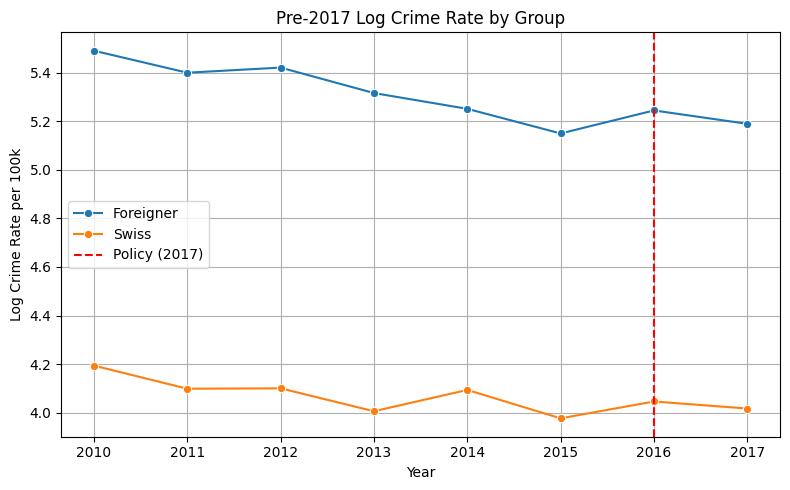

In [58]:
# Clean data (remove rows with missing crime_rate_per_100k)
df = df.dropna(subset=['population'])
df = df[df['crime_rate_per_100k'] > 0].copy()
df['log_crime_rate'] = np.log(df['crime_rate_per_100k'])
df = df[df['year'] <= 2017].copy()



plt.figure(figsize=(8,5))
sns.lineplot(data=df, x='year', y='log_crime_rate', hue='group', marker='o')
plt.axvline(2016, color='red', linestyle='--', label='Policy (2017)')
plt.title("Pre-2017 Log Crime Rate by Group")
plt.xlabel("Year"); plt.ylabel("Log Crime Rate per 100k")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.savefig("/Users/souhil/Desktop/Courses/Recherche Empirique/Final/pre_2017_trend_loglin.png", dpi=300, bbox_inches='tight')  
plt.show()

## Linear Time‐Trend & Interaction Test

Here we estimate the model

$\log (\text{crime\_rate}_{gt}) = \alpha + \beta \times \text{t}+ \delta \cdot (\text{T}_g \times \text{t}) + \varepsilon_{gt}$

where
- $t = \text{year} - 2009$ is a common linear time trend,  
- $T_{g}=1$ for Foreigners (0 for Swiss),  
- $\beta$ captures the overall (common) pre‐policy trend,  
- $\delta$ tests whether **the trend differs** for Foreigners vs. Swiss.

The null $H_0: \delta = 0$ implies perfectly parallel trends after accounting for the baseline slope.  




Result: $\delta = +0.2807, p=0.01$, **reject parallel trends**.

In [59]:
# Slope interaction test (with standalone time trend)
df_pre = df[df['year'] < 2017].copy()  
df_pre['t'] = df_pre['year'] - df_pre['year'].min()  
df_pre['T'] = (df_pre['group'] == 'Foreigner').astype(int)  
df_pre['T_t'] = df_pre['T'] * df_pre['t'] 

m1 = smf.ols("log_crime_rate ~ t + T_t", data=df_pre).fit()  

print('\nSlope Interaction Test for Parallel Trends\n')
print(m1.summary())

# Directly show the key coefficient
print("\n--> Key Parallel Trends Test: Coefficient for T_t =", 
      f"{m1.params['T_t']:.4f} (p-value = {m1.pvalues['T_t']:.4f})")
print("--> Null hypothesis: T_t coefficient = 0 (parallel trends)")
print("--> If p > 0.05, no evidence against parallel trends")


Slope Interaction Test for Parallel Trends

                            OLS Regression Results                            
Dep. Variable:         log_crime_rate   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                     10.48
Date:                Tue, 27 May 2025   Prob (F-statistic):            0.00284
Time:                        12:33:10   Log-Likelihood:                -5.9697
No. Observations:                  14   AIC:                             17.94
Df Residuals:                      11   BIC:                             19.86
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Interce

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=14 observations were given.
  return hypotest_fun_in(*args, **kwds)


## Group $\times$ Year Linear Interaction Test

$\log (CR_{gt}) = \alpha + \gamma T_g + \lambda \text{t} + \beta (T_g \times \text{t}) + \varepsilon_{gt}.$


In [60]:
# Group × Year linear interaction test
m2 = smf.ols("log_crime_rate ~ T + year + T:year", data=df_pre).fit()
print("\n--- Group × Year Interaction Test ---")
print(m2.summary())


--- Group × Year Interaction Test ---
                            OLS Regression Results                            
Dep. Variable:         log_crime_rate   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     666.3
Date:                Tue, 27 May 2025   Prob (F-statistic):           8.26e-12
Time:                        12:33:10   Log-Likelihood:                 23.685
No. Observations:                  14   AIC:                            -39.37
Df Residuals:                      10   BIC:                            -36.81
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=14 observations were given.
  return hypotest_fun_in(*args, **kwds)



## Event-Study Pre-Trends Test

Done on the canton dataset

$\log(CR_{cgt})= \alpha\;+\;\gamma\,FG_{g}\;+\;\sum_{y=2010}^{2016}\delta_{y}\,1\{Year=y\}\;+\;\sum_{y=2010}^{2016}\theta_{y}\,(FG_{g}\times 1\{Year=y\})\;+\;FE_{c}\;+\;\varepsilon_{cgt}$

where  
- $FG_{g}=1$ if group \(g\) is Foreigner (0 if Swiss),  
- $FE_{c}$ are canton fixed effects,  
- the **base year** $2010$ is omitted.  

**Null hypothesis**:  
$H_{0}:\;\theta_{2010}=\theta_{2011}=\dots=\theta_{2016}=0.$

In [61]:
df_pre = pd.read_excel("/Users/souhil/Desktop/Courses/Recherche Empirique/Final/Data/cleaned/crimes_subject_to_law_cleaned_by_canton.xlsx")

# Pre‐treatment & log‐transform
df_pre = df_pre[df_pre['year'] < 2017].copy()
df_pre = df_pre[df_pre['crime_rate_per_100k'] > 0]
df_pre['log_crime_rate'] = np.log(df_pre['crime_rate_per_100k'])

# Dummies
df_pre['FG'] = (df_pre['group']=='Foreigner').astype(int)
df_pre['year_cat'] = df_pre['year'].astype('category')

# Event‐study regression with canton fixed effects
model = smf.ols("log_crime_rate ~ FG + C(year_cat) + C(year_cat):FG + C(canton)",
                data=df_pre).fit(cov_type='cluster', cov_kwds={'groups': df_pre['canton']})

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         log_crime_rate   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     207.9
Date:                Tue, 27 May 2025   Prob (F-statistic):           6.79e-20
Time:                        12:33:10   Log-Likelihood:                -123.60
No. Observations:                 272   AIC:                             319.2
Df Residuals:                     236   BIC:                             449.0
Df Model:                          35                                         
Covariance Type:              cluster                                         
                                                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 35, but rank is 13
  warnings.warn('covariance of constraints does not have full '


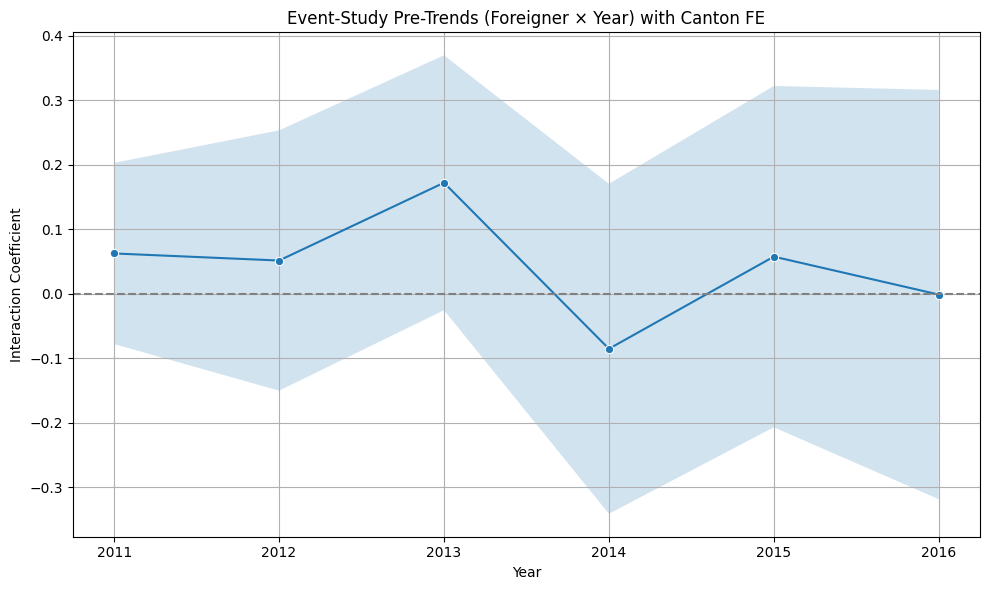

In [62]:
# Extract and plot θ_y = the Foreigner×Year interactions
ints = model.params.filter(like="C(year_cat)[T.").filter(like=":FG")  # Use `like=` as keyword argument
ses = model.bse[ints.index]

# Extract years from coefficient names (e.g., "C(year_cat)[T.2011]:FG" → 2011)
years = [int(s.split('T.')[1].split(']')[0]) for s in ints.index]

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(x=years, y=ints.values, marker='o')
plt.fill_between(years, ints - 1.96*ses, ints + 1.96*ses, alpha=0.2)
plt.axhline(0, color='gray', linestyle='--')
plt.title("Event-Study Pre-Trends (Foreigner × Year) with Canton FE")
plt.xlabel("Year"); plt.ylabel("Interaction Coefficient")
plt.grid(True); plt.tight_layout()
plt.savefig("/Users/souhil/Desktop/Courses/Recherche Empirique/Final/foreigner_year_interaction.png", dpi=300, bbox_inches='tight')  
plt.show()

In [63]:
# Get all interaction terms
interaction_terms = [
    term for term in model.params.index 
    if "C(year_cat)[T." in term and ":FG" in term
]

# Formulate the null hypothesis: θ_2011 = θ_2012 = ... = 0
hypothesis = " + ".join(interaction_terms) + " = 0"

# Perform the test
joint_test = model.f_test(hypothesis)
print("\nJoint Test for All Foreigner×Year Interactions = 0")
print(f"F-statistic: {joint_test.fvalue:.2f}")
print(f"p-value: {joint_test.pvalue:.4f}")


Joint Test for All Foreigner×Year Interactions = 0
F-statistic: 0.32
p-value: 0.5748


> **Bottom line:**  We have mixed evidence.  To be fully credible, we must adjust our DiD for any residual trend differences.  

## Specification : Box-Cox transformation

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Optimal λ≈ 0.250
Approx 95% CI: [0.170, 0.340]


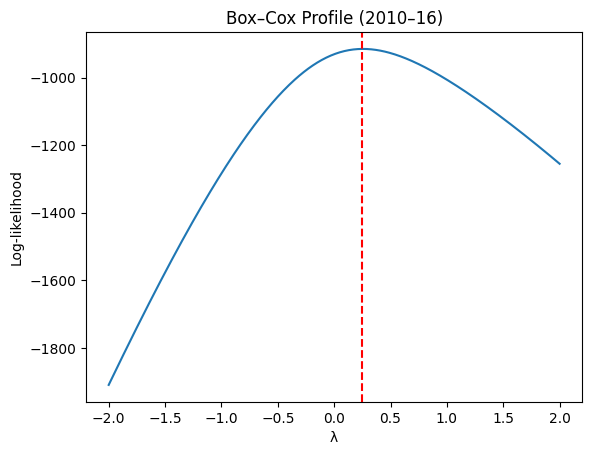

In [64]:
df_ct = pd.read_excel("/Users/souhil/Desktop/Courses/Recherche Empirique/Final/Data/cleaned/crimes_subject_to_law_cleaned_by_canton.xlsx")

df_ct['log_crime_rate'] = np.log(df_ct['crime_rate_per_100k'])
df_ct = df_ct[df_ct['log_crime_rate']>=0]
df_ct['T'] = (df_ct['group']=="Foreigner").astype(int)
df_ct['P'] = (df_ct['year']>=2017).astype(int)
df_ct['T_P'] = df_ct['T'] * df_ct['P']
df_ct['t'] = df_ct['year'] - df_ct['year'].min()
df_ct['T_t'] = df_ct['T'] * df_ct['t']

# 1) Pre‐treatment subset
df_pre = df_ct[df_ct['year'] < 2017].copy()
y = df_pre['crime_rate_per_100k'].values
n = len(y)

# 2) Set up grid of λ
lambdas = np.linspace(-2, 2, 401)
llf = []

# 3) Loop: transform, regress on FEs, compute log‐likelihood
for lam in lambdas:
    # transform
    if abs(lam) < 1e-6:
        yt = np.log(y)
    else:
        yt = (y**lam - 1) / lam

    # attach back to df
    df_pre['yt'] = yt

    # fit with canton + group + (optional year) FEs
    # here we use just canton & group to keep things simple
    mod = smf.ols("yt ~ C(canton) + C(group)", data=df_pre).fit()
    rss = np.sum(mod.resid**2)

    # log‐likelihood up to constant
    ll = - (n/2) * np.log(rss / n) + (lam - 1) * np.sum(np.log(y))
    llf.append(ll)

# 4) Gather and find optimum
df_bc = pd.DataFrame({'lambda': lambdas, 'llf': llf})
best = df_bc.loc[df_bc['llf'].idxmax()]

print(f"Optimal λ≈ {best['lambda']:.3f}")
# Optionally: 95% CI where llf ≥ max(llf) - χ²(1,0.95)/2 ≈ drop of 1.92
crit = best['llf'] - 1.92
ci = df_bc.loc[df_bc['llf'] >= crit, 'lambda'].agg(['min','max'])
print(f"Approx 95% CI: [{ci['min']:.3f}, {ci['max']:.3f}]")

# 5) Show the full profile (optional)
import matplotlib.pyplot as plt
plt.plot(df_bc['lambda'], df_bc['llf'])
plt.axvline(best['lambda'], color='red', linestyle='--')
plt.xlabel('λ')
plt.ylabel('Log‐likelihood')
plt.title('Box–Cox Profile (2010–16)')
plt.savefig("/Users/souhil/Desktop/Courses/Recherche Empirique/Final/BoxCoxProfile.png", dpi=300, bbox_inches='tight')  
plt.show()